# **Mount Google Drive**

In [167]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Import Libraries**

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from collections import Counter
import random

# **Load & Preprocess Image**

In [169]:
def load_images(dataset_path, target_size=(32, 32)):

    images = []
    labels = []


    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)


                    img = Image.open(img_path).convert('L') #convert to grayscale
                    img = img.resize(target_size)           # Resize
                    img_array = np.array(img).flatten()     # Convert to numpy array


                    images.append(img_array)
                    labels.append(class_name)

    return np.array(images), np.array(labels)


dataset='/content/gdrive/MyDrive/CVPR/animal_dataset'

images, labels = load_images(dataset)


print(f"Loaded {len(images)} images")
print(f"Image shape: {images[0].shape}")
print(f"Unique labels: {np.unique(labels)}")


Loaded 300 images
Image shape: (1024,)
Unique labels: ['cat' 'dog' 'panda']


# **Plot sample preprocessed images**

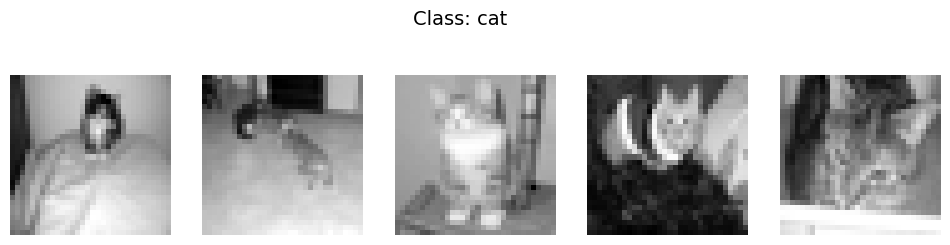

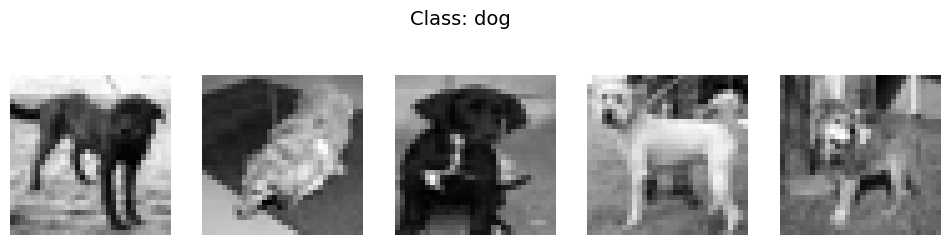

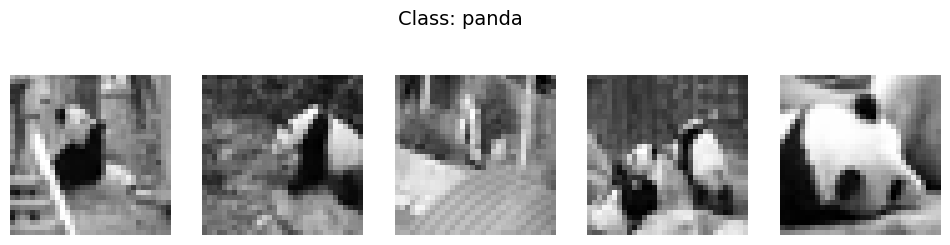

In [170]:
img_size=(32,32)
unique_classes = np.unique(labels)

for cls in unique_classes:
  class_indices = np.where(labels == cls)[0]
  sampled_idx = np.random.choice(class_indices,size=min(5, len(class_indices)),replace=False)

  # Create figure
  plt.figure(figsize=(12, 3))

  for i, idx in enumerate(sampled_idx):
      plt.subplot(1, 5, i + 1)
      plt.imshow(images[idx].reshape(img_size), cmap="gray")
      plt.axis("off")

  plt.suptitle(f"Class: {cls}", fontsize=14)
  plt.show()


# **Define Distance Functions**

In [171]:
def manhattan_distance(img1, img2):
    return np.sum(np.abs(img1 - img2))

def euclidean_distance(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))

# **Define KNN function**

In [172]:
def get_neighbors(training_imgs, training_labels, test_img, k, distance_func):

    distances = []

    for i in range(len(training_imgs)):
        dist = distance_func(test_img, training_imgs[i])
        distances.append((training_labels[i], dist))

    # Sort by distance
    distances.sort(key=lambda x: x[1])

    # Get k nearest neighbors
    neighbors = [distances[i][0] for i in range(k)]
    return neighbors

def predict(neighbors):
    """Predict class based on majority vote of neighbors"""
    counter = Counter(neighbors)
    return counter.most_common(1)[0][0]

# **Define 5 fold cross Validation**

In [173]:
def create_folds(images, labels, k_folds=5):

    n = len(images)
    indices = list(range(n))
    np.random.shuffle(indices)

    fold_size = n // k_folds
    folds = []

    for i in range(k_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k_folds - 1 else n
        test_indices = indices[start:end]
        train_indices = indices[:start] + indices[end:]

        folds.append({
            'train_imgs': images[train_indices],
            'train_labels': labels[train_indices],
            'test_imgs': images[test_indices],
            'test_labels': labels[test_indices]
        })

    return folds

# Create folds
folds = create_folds(images, labels, k_folds=5)
print(f"Created {len(folds)} folds")
print(f"Training samples per fold: {len(folds[0]['train_imgs'])}")
print(f"Test samples per fold: {len(folds[0]['test_imgs'])}")

Created 5 folds
Training samples per fold: 240
Test samples per fold: 60


# **Calculate Distances for both distance function with cross validation**

In [174]:
def cross_validate(folds, k_values, distance_func, distance_name):

    results = {k: [] for k in k_values}

    for fold_idx, fold in enumerate(folds):
        print(f"Processing fold {fold_idx + 1} for {distance_name}...")

        train_imgs = fold['train_imgs']
        train_labels = fold['train_labels']
        test_imgs = fold['test_imgs']
        test_labels = fold['test_labels']

        for k in k_values:
            correct = 0
            total = len(test_imgs)

            for i in range(total):
                neighbors = get_neighbors(train_imgs, train_labels, test_imgs[i], k, distance_func)
                prediction = predict(neighbors)

                if prediction == test_labels[i]:
                    correct += 1

            accuracy = correct / total
            results[k].append(accuracy)

    # Calculate average accuracy for each k
    avg_results = {k: np.mean(accuracies) for k, accuracies in results.items()}
    return avg_results


k_values = [1, 3, 5, 7, 9]

print("Calculating Manhattan (L1) distances...")
l1_results = cross_validate(folds, k_values, manhattan_distance, "Manhattan")

print("Calculating Euclidean (L2) distances...")
l2_results = cross_validate(folds, k_values, euclidean_distance, "Euclidean")

print("Cross-validation completed!")

Calculating Manhattan (L1) distances...
Processing fold 1 for Manhattan...
Processing fold 2 for Manhattan...
Processing fold 3 for Manhattan...
Processing fold 4 for Manhattan...
Processing fold 5 for Manhattan...
Calculating Euclidean (L2) distances...
Processing fold 1 for Euclidean...
Processing fold 2 for Euclidean...
Processing fold 3 for Euclidean...
Processing fold 4 for Euclidean...
Processing fold 5 for Euclidean...
Cross-validation completed!


# **Plot the accuracies for both distance function**

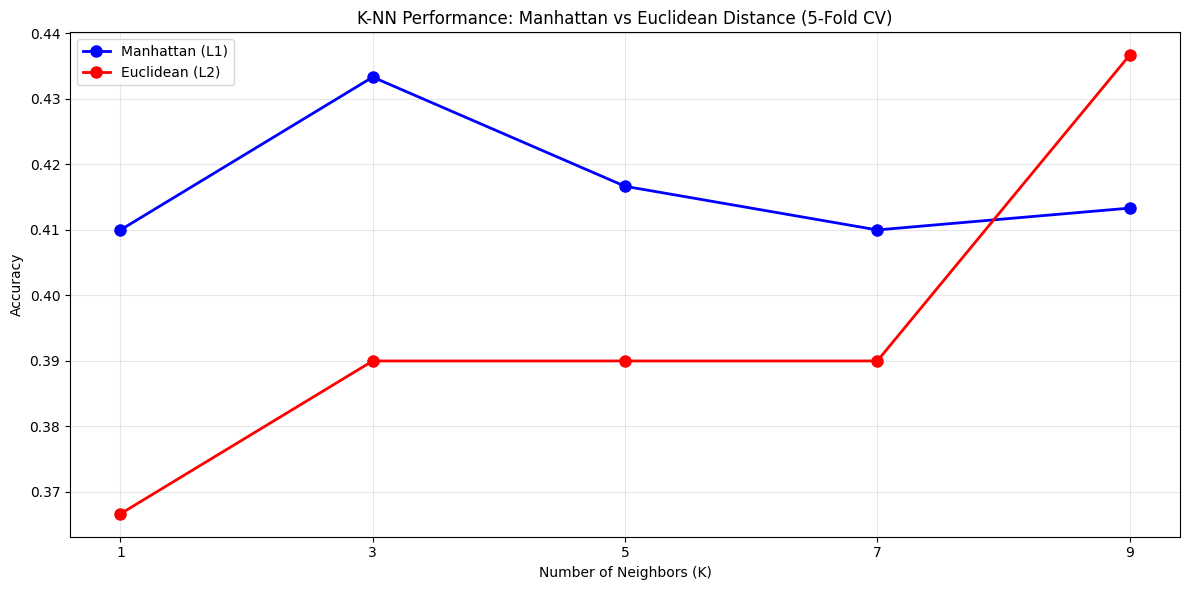

In [175]:
# Extract data for plotting
k_list = list(k_values)
l1_accuracies = [l1_results[k] for k in k_values]
l2_accuracies = [l2_results[k] for k in k_values]

# Create plot
plt.figure(figsize=(12, 6))
plt.plot(k_list, l1_accuracies, 'bo-', label='Manhattan (L1)', linewidth=2, markersize=8)
plt.plot(k_list, l2_accuracies, 'ro-', label='Euclidean (L2)', linewidth=2, markersize=8)

plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('K-NN Performance: Manhattan vs Euclidean Distance (5-Fold CV)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(k_values)


plt.tight_layout()
plt.show()

# **Select the best k_value and distance function**

In [176]:
print("\nAverage Accuracy for Different K Values:")
print("K\tManhattan (L1)\tEuclidean (L2)")
print("-" * 40)
for k in k_values:
    print(f"{k}\t{l1_results[k]:.4f}\t\t{l2_results[k]:.4f}")

# Find best performing k for each distance
best_k_l1 = max(l1_results, key=l1_results.get)
best_k_l2 = max(l2_results, key=l2_results.get)

print(f"\nBest K for Manhattan: {best_k_l1} (Accuracy: {l1_results[best_k_l1]:.4f})")
print(f"Best K for Euclidean: {best_k_l2} (Accuracy: {l2_results[best_k_l2]:.4f})")

# Determine which distance metric performed better
if l1_results[best_k_l1] > l2_results[best_k_l2]:
    print(f"\nBest Distance Function: Manhattan (L1)")
    best_distance = manhattan_distance
    best_k = best_k_l1
else:
    print(f"\nBest Distance Function: Euclidean (L2)")
    best_distance = euclidean_distance
    best_k = best_k_l2


Average Accuracy for Different K Values:
K	Manhattan (L1)	Euclidean (L2)
----------------------------------------
1	0.4100		0.3667
3	0.4333		0.3900
5	0.4167		0.3900
7	0.4100		0.3900
9	0.4133		0.4367

Best K for Manhattan: 3 (Accuracy: 0.4333)
Best K for Euclidean: 9 (Accuracy: 0.4367)

Best Distance Function: Euclidean (L2)


# **Predict Best images for best k_value and distance function**

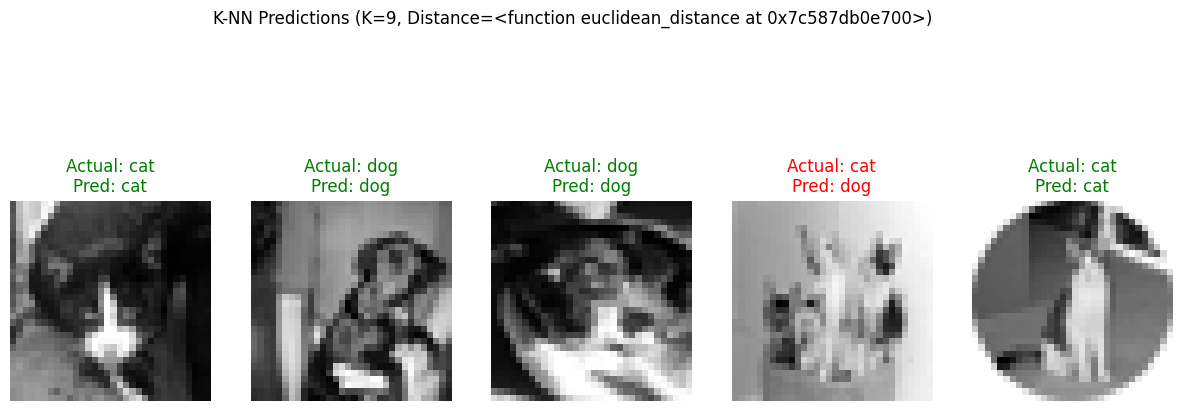

In [178]:
fold = folds[k_values.index(best_k)]
train_imgs = fold['train_imgs']
train_labels = fold['train_labels']
test_imgs = fold['test_imgs']
test_labels = fold['test_labels']

# Select 5 random images
num_samples = 5
random_indices = random.sample(range(len(test_imgs)), num_samples)

predictions_data = []

for i in random_indices:
    test_image = test_imgs[i]
    actual_label = test_labels[i]

    # Get neighbors and predict
    neighbors = get_neighbors(train_imgs, train_labels, test_image, best_k, best_distance)
    predicted_label = predict(neighbors)

    is_correct = (predicted_label == actual_label)
    predictions_data.append({
        'test_index': i,
        'test_image': test_image,
        'actual_label': actual_label,
        'predicted_label': predicted_label,
        'neighbors': neighbors,
        'correct': is_correct
    })

# Plot the results
plt.figure(figsize=(15, 6))
for i, pred_info in enumerate(predictions_data):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(pred_info['test_image'].reshape(img_size), cmap='gray')

    color = 'green' if pred_info['correct'] else 'red'

    title_text = f"Actual: {pred_info['actual_label']}\nPred: {pred_info['predicted_label']}"
    plt.title(title_text, color=color)
    plt.axis('off')

plt.suptitle(f'K-NN Predictions (K={best_k}, Distance={best_distance})')
plt.show()